# Imports

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
import io
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import torch 
import torch.nn.functional as F
from torch import flatten
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch import nn
import time
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Reading Data

In [ ]:
link = 'https://drive.google.com/file/d/1RqBOAVQyZOQLPBN6eNDbBOWLDNIB_LR6/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('magic04.data')

In [ ]:
dataframe = pd.read_csv('magic04.data')

# Splitting Data

In [ ]:
data, labels = dataframe.iloc[:, :-1], dataframe.iloc[:, -1]
rus = RandomUnderSampler()
data_res, labels_res = rus.fit_resample(data, labels)
data_res, labels_res = np.array(data_res), np.array(labels_res)
x_train, x_test, y_train, y_test = train_test_split(data_res, labels_res, shuffle = True, test_size=0.3, stratify=labels_res)

In [ ]:
print(np.array(x_train).shape)

(9363, 10)


In [ ]:
print(np.unique(y_test, return_counts=True))

(array(['g', 'h'], dtype=object), array([2006, 2007]))


# Plotting Code

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plotting(output1,output2,accuracy): 
  fig = plt.figure()
  
  ax = fig.add_subplot(111, projection='3d')
  
  
  # plotting
  ax.scatter(output1, output2, accuracy)
  ax.set_title('Accuracy plot')
  plt.show()

# Data Class

In [ ]:
class MagicDataset(Dataset):
    def __init__(self, data, labels):
        self.labels = labels
        self.data = data
        self.dict_labels = {'g': 0, 'h': 1}

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        data = torch.tensor(self.data[index])
        label = self.labels[index]
        return data, torch.tensor(self.dict_labels[label])

# Model Class

In [ ]:
class TestModel(nn.Module):
    def __init__(self, output1, output2):
        super(TestModel, self).__init__()
        self.fc1 = nn.Linear(10, output1)
        self.fc2 = nn.Linear(output1, output2)
        self.fc3 = nn.Linear(output2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)

# Running Function

In [ ]:
def tvt(optimizer, mode, model, dataloader):
  if mode == 'train':
    model.train()
    numberOfBatches = trainSteps
  totalLoss = 0
  correctPred = 0
  preds = []
  batchNumber = 1
  lossFn = nn.BCELoss()
  for (data, labels) in dataloader:
        data = data.float()
        pred = model(data)
        pred = pred.squeeze(1)
        temp = pred.detach().cpu().numpy().copy()
        for i in range(len(pred)):
          temp[i] = 0. if temp[i] <= 0.5 else 1.
        loss = lossFn(pred, labels.float())
        totalLoss += loss
        compare = [1 if i==j else 0 for i, j in zip(temp,labels)]
        correctPred += np.array(compare).sum()
        if mode == 'train':
          optimizer.zero_grad() 
          loss.backward()  
          optimizer.step()
        preds.extend(np.array(compare))
        batchNumber += 1
  return totalLoss/len(dataloader), correctPred, preds

# Classifier

In [ ]:
def Classifier(x_train, y_train, x_val, y_val, hyp):
  training_data = MagicDataset(x_train, y_train)
  testing_data = MagicDataset(x_test, y_test)

  trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=hyp[1])
  testDataLoader = DataLoader(testing_data, batch_size=hyp[1])
  trainSteps = len(trainDataLoader.dataset) // hyp[1]

  model = TestModel(hyp[3], hyp[4])
  opt = Adam(model.parameters(), lr=hyp[0])

  for e in range(hyp[2]):
    tvt(opt, 'train', model, trainDataLoader)
    
  _,  _, preds = tvt(opt, 'test', model, testDataLoader)
  enumLabels = []
  for label in testing_data.labels:
      enumLabels.append(testing_data.dict_labels[label])

  return accuracy_score(enumLabels, preds)

# Cross Validator

In [ ]:
def CrossValidate(x_train, y_train, hyp):
  k = 5
  kf = KFold(n_splits=5)
  kf.get_n_splits(x_train)
  acc = 0
  for train_index, test_index in kf.split(x_train):
      KFX_train, KFX_test = x_train[train_index], x_train[test_index]
      KFy_train, KFy_test = y_train[train_index], y_train[test_index]
      acc += Classifier(KFX_train, KFy_train, KFX_test,  KFy_test, hyp)
  return acc/k

# HyperParameters

In [ ]:
INIT_LR = 1e-5
BATCH_SIZE = 9363
EPOCHS = 20

# Cross Validate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ValAccuracies = []
for i in range(8, 64, 4):
  for j in range(8, 64, 4):
    hyperparameters = [INIT_LR, BATCH_SIZE, EPOCHS, i, j]
    ValAccuracies.append([i, j, CrossValidate(x_train, y_train, hyperparameters)])

In [ ]:
PATH = "/content/gdrive/MyDrive/Project 3/ValAccuracies.npy"
np.save(PATH, np.array(ValAccuracies))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Validations_accuracies=np.load("/content/drive/MyDrive/Project 3/ValAccuracies.npy")

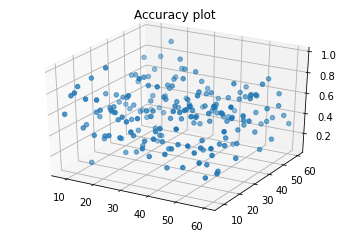

In [ ]:
plotting(Validations_accuracies[:,0],Validations_accuracies[:,1],Validations_accuracies[:,2])

In [ ]:
V_Accuracies=Validations_accuracies[:,2]

In [ ]:
max_index =V_Accuracies.argmax()
max_=Validations_accuracies[max_index]
print(max_)

[16.         20.          0.97258909]


In [ ]:
ValAccuracies1 = []
for i in range(14,18,1):
  for j in range(18,22,1):
    hyperparameters = [INIT_LR, BATCH_SIZE, EPOCHS, i, j]
    ValAccuracies1.append([i, j, CrossValidate(x_train, y_train, hyperparameters)])

In [ ]:
PATH = "/content/gdrive/MyDrive/Project 3/ValAccuracies1.npy"
np.save(PATH, np.array(ValAccuracies1))

In [ ]:
Validations_accuracies1=np.load("/content/gdrive/MyDrive/Project 3/ValAccuracies1.npy")

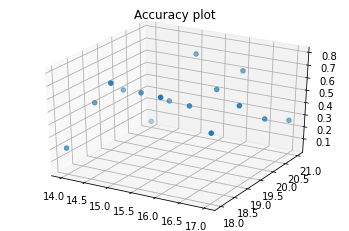

In [ ]:
plotting(Validations_accuracies1[:,0],Validations_accuracies1[:,1],Validations_accuracies1[:,2])

In [ ]:
V_Accuracies1=Validations_accuracies1[:,2]

In [ ]:
max_index1 =V_Accuracies1.argmax()
max_1=Validations_accuracies1[max_index1]
print(max_1)

[15.         18.          0.78460005]


In [ ]:
training_data = MagicDataset(x_train, y_train)
testing_data = MagicDataset(x_test, y_test)

In [ ]:
INIT_LR = 1e-5
BATCH_SIZE = 1024
EPOCHS = 100
output1 = int(max_1[0])
output2 = int(max_1[1])

In [ ]:
trainDataLoader = DataLoader(training_data, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testing_data, batch_size=BATCH_SIZE)
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE

In [ ]:
model = TestModel(output1, output1)
opt = SGD(model.parameters(), lr=INIT_LR)
trainLoss,trainAcc, validationLoss, validationAcc = [], [], [], []
print("Training Model")
for e in range(EPOCHS):
  print('Epoch {0}/{1}'.format(e+1,EPOCHS))
  avgTrainLoss, correctPred, _ = tvt(opt, 'train', model, trainDataLoader)
  print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, correctPred/len(trainDataLoader.dataset)))
  trainLoss.append(avgTrainLoss.item())
  trainAcc.append(correctPred/len(trainDataLoader.dataset)*100)
print('\nTesting:')
_,  _, preds = tvt(opt, 'test', model, testDataLoader)
enumLabels = []
for label in testing_data.labels:
    enumLabels.append(testing_data.dict_labels[label])
print(f"MODEL {output1} X {output1}")
print(classification_report(np.array(enumLabels), np.array(preds)))
accuracy = accuracy_score(enumLabels, preds)
print('Accuracy = {0} '.format(accuracy*100))

Training Model
Epoch 1/100
Train loss: 2.507279, Train accuracy: 0.4933
Epoch 2/100
Train loss: 1.068700, Train accuracy: 0.4959
Epoch 3/100
Train loss: 0.946201, Train accuracy: 0.5450
Epoch 4/100
Train loss: 0.899748, Train accuracy: 0.5567
Epoch 5/100
Train loss: 0.864595, Train accuracy: 0.5606
Epoch 6/100
Train loss: 0.838342, Train accuracy: 0.5602
Epoch 7/100
Train loss: 0.817165, Train accuracy: 0.5638
Epoch 8/100
Train loss: 0.799752, Train accuracy: 0.5632
Epoch 9/100
Train loss: 0.784162, Train accuracy: 0.5645
Epoch 10/100
Train loss: 0.770979, Train accuracy: 0.5670
Epoch 11/100
Train loss: 0.757422, Train accuracy: 0.5685
Epoch 12/100
Train loss: 0.746009, Train accuracy: 0.5723
Epoch 13/100
Train loss: 0.735457, Train accuracy: 0.5746
Epoch 14/100
Train loss: 0.724917, Train accuracy: 0.5768
Epoch 15/100
Train loss: 0.715763, Train accuracy: 0.5793
Epoch 16/100
Train loss: 0.706699, Train accuracy: 0.5838
Epoch 17/100
Train loss: 0.698633, Train accuracy: 0.5874
Epoch 18